In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import folium
from haversine import haversine, Unit
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 22.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [20, 6]

import warnings
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_excel('data/27(거래금액,등락율,전세가율,건축년도,건물연령,전용면적,관리시설수,주택금융여부).xlsx')
df

,Unnamed: 0,ID,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,연령,거래금액(만원)_18/2,...,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,연령.17,관리시설수,위도,경도
0,0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.0,0,4.162633,32.7,80,1987.0,31.0,145000.0,...,218666.7,0,1.7,27.1,80,1987.0,35.0,NaN,37.483372,127.053437
1,1,서울특별시 강남구 개포동 개포주공1단지 40,145736.8,0,16.507998,7.0,40,1982.0,36.0,162587.5,...,180000.0,0,0.0,5.6,40,1982.0,40.0,NaN,37.483381,127.057068
2,2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,0,0.000000,31.2,60,1983.0,35.0,129500.0,...,202800.0,0,0.0,21.8,60,1983.0,39.0,5.0,37.487868,127.068988
3,3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,0,0.000000,25.4,80,1983.0,35.0,177416.7,...,282250.0,0,0.0,22.1,80,1983.0,39.0,5.0,37.487868,127.068988
4,4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,0,9.134234,30.1,50,1983.0,35.0,128000.0,...,189000.0,0,0.0,22.8,50,1983.0,39.0,3.0,37.488481,127.072502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,4294,서울특별시 중랑구 중화동 중화동건영아파트 60,25000.0,1,6.000000,10.0,60,1998.0,20.0,27000.0,...,47500.0,1,0.0,50.8,60,1998.0,24.0,NaN,37.605430,127.082936
4087,4295,서울특별시 중랑구 중화동 태능에셈빌 80,35000.0,1,0.000000,42.9,80,2005.0,13.0,36875.0,...,71000.0,0,0.0,21.1,80,2005.0,17.0,NaN,37.599447,127.078938
4088,4296,서울특별시 중랑구 중화동 한신아파트 50,31756.2,1,0.000000,77.4,50,1997.0,21.0,32190.0,...,70000.0,0,0.0,52.9,50,1997.0,25.0,5.0,37.595961,127.080314
4089,4297,서울특별시 중랑구 중화동 한신아파트 60,36534.6,1,2.996064,76.9,60,1997.1,20.9,38387.5,...,73000.0,0,0.0,49.5,60,1997.1,24.9,5.0,37.595961,127.080314


In [23]:
del df['Unnamed: 0']

In [24]:
df.dropna(inplace=True)

In [25]:
df.head()

,ID,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,연령,거래금액(만원)_18/2,주택금융가능여부.1,...,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,연령.17,관리시설수,위도,경도
2,서울특별시 강남구 개포동 개포주공5단지 60,136666.7,0,0.000000,31.2,60,1983.0,35.0,129500.0,0,...,202800.0,0,0.0,21.8,60,1983.0,39.0,5.0,37.487868,127.068988
3,서울특별시 강남구 개포동 개포주공5단지 80,177416.7,0,0.000000,25.4,80,1983.0,35.0,177416.7,0,...,282250.0,0,0.0,22.1,80,1983.0,39.0,5.0,37.487868,127.068988
4,서울특별시 강남구 개포동 개포주공6단지 50,125900.0,0,9.134234,30.1,50,1983.0,35.0,128000.0,0,...,189000.0,0,0.0,22.8,50,1983.0,39.0,3.0,37.488481,127.072502
5,서울특별시 강남구 개포동 개포주공6단지 60,135200.0,0,9.023669,31.8,60,1983.0,35.0,131650.0,0,...,181000.0,0,0.0,21.7,60,1983.0,39.0,3.0,37.488481,127.072502
6,서울특별시 강남구 개포동 개포주공6단지 70,151500.0,0,10.451045,33.2,70,1983.0,35.0,150500.0,0,...,270000.0,0,0.0,21.2,70,1983.0,39.0,3.0,37.488481,127.072502


In [26]:
where = df.iloc[:,128:130]
where

,위도,경도
2,37.487868,127.068988
3,37.487868,127.068988
4,37.488481,127.072502
5,37.488481,127.072502
6,37.488481,127.072502
...,...,...
4083,37.604124,127.082326
4084,37.594222,127.075432
4088,37.595961,127.080314
4089,37.595961,127.080314


In [27]:
gongtong = df.iloc[:,127]
gongtong

2       5.0
3       5.0
4       3.0
5       3.0
6       3.0
       ... 
4083    4.0
4084    4.0
4088    5.0
4089    5.0
4090    5.0
Name: 관리시설수, Length: 3295, dtype: float64

In [28]:
df.iloc[:,1:8]

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,연령
2,136666.7,0,0.000000,31.2,60,1983.0,35.0
3,177416.7,0,0.000000,25.4,80,1983.0,35.0
4,125900.0,0,9.134234,30.1,50,1983.0,35.0
5,135200.0,0,9.023669,31.8,60,1983.0,35.0
6,151500.0,0,10.451045,33.2,70,1983.0,35.0
...,...,...,...,...,...,...,...
4083,36300.0,1,13.223140,35.8,80,1991.0,27.0
4084,44000.0,1,0.000000,85.2,80,2010.0,8.0
4088,31756.2,1,0.000000,77.4,50,1997.0,21.0
4089,36534.6,1,2.996064,76.9,60,1997.1,20.9


In [29]:
dic = {}
num = 1

for i1 in range(1,19):
    dic[f'data{i1}'] = df.iloc[:,num:num+7]
    dic[f'data{i1}'] = pd.concat([dic[f'data{i1}'],gongtong], axis=1)
    num += 7

dic['data1']

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,연령,관리시설수
2,136666.7,0,0.000000,31.2,60,1983.0,35.0,5.0
3,177416.7,0,0.000000,25.4,80,1983.0,35.0,5.0
4,125900.0,0,9.134234,30.1,50,1983.0,35.0,3.0
5,135200.0,0,9.023669,31.8,60,1983.0,35.0,3.0
6,151500.0,0,10.451045,33.2,70,1983.0,35.0,3.0
...,...,...,...,...,...,...,...,...
4083,36300.0,1,13.223140,35.8,80,1991.0,27.0,4.0
4084,44000.0,1,0.000000,85.2,80,2010.0,8.0,4.0
4088,31756.2,1,0.000000,77.4,50,1997.0,21.0,5.0
4089,36534.6,1,2.996064,76.9,60,1997.1,20.9,5.0


In [30]:
dic['data18']

,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,연령.17,관리시설수
2,202800.0,0,0.0,21.8,60,1983.0,39.0,5.0
3,282250.0,0,0.0,22.1,80,1983.0,39.0,5.0
4,189000.0,0,0.0,22.8,50,1983.0,39.0,3.0
5,181000.0,0,0.0,21.7,60,1983.0,39.0,3.0
6,270000.0,0,0.0,21.2,70,1983.0,39.0,3.0
...,...,...,...,...,...,...,...,...
4083,56933.3,1,0.0,83.4,80,1991.0,31.0,4.0
4084,78800.0,0,0.0,44.4,80,2010.0,12.0,4.0
4088,70000.0,0,0.0,52.9,50,1997.0,25.0,5.0
4089,73000.0,0,0.0,49.5,60,1997.1,24.9,5.0


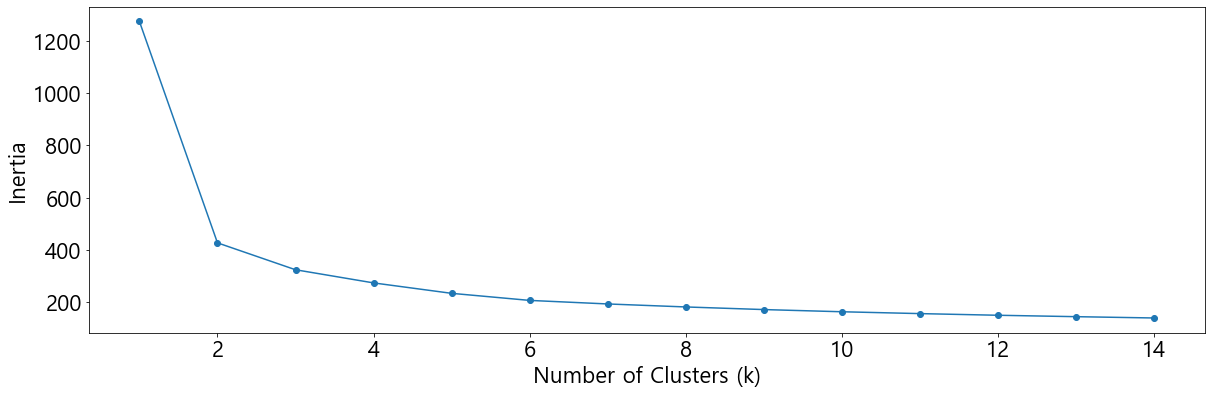

In [31]:
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(dic['data1'])
samples = pd.DataFrame(mm_scaled)

num_clusters = list(range(1, 15))
inertias = []

for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [42]:
# 스케일링과 클러스터링
mm = StandardScaler()
mm_scaled1 = mm.fit_transform(dic['data1'])
mm_scaled2 = mm.fit_transform(dic['data2'])
mm_scaled3 = mm.fit_transform(dic['data3'])
mm_scaled4 = mm.fit_transform(dic['data4'])
mm_scaled5 = mm.fit_transform(dic['data5'])
mm_scaled6 = mm.fit_transform(dic['data6'])
mm_scaled7 = mm.fit_transform(dic['data7'])
mm_scaled8 = mm.fit_transform(dic['data8'])
mm_scaled9 = mm.fit_transform(dic['data9'])
mm_scaled10 = mm.fit_transform(dic['data10'])
mm_scaled11 = mm.fit_transform(dic['data11'])
mm_scaled12 = mm.fit_transform(dic['data12'])
mm_scaled13 = mm.fit_transform(dic['data13'])
mm_scaled14 = mm.fit_transform(dic['data14'])
mm_scaled15 = mm.fit_transform(dic['data15'])
mm_scaled16 = mm.fit_transform(dic['data16'])
mm_scaled17 = mm.fit_transform(dic['data17'])
mm_scaled18 = mm.fit_transform(dic['data18'])

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=np.random.RandomState(seed=1))

clusters1 = kmeans.fit(mm_scaled1)
dic['data1']['cluster'] = clusters1.labels_
clusters2 = kmeans.predict(mm_scaled2)
dic['data2']['cluster'] = clusters2
clusters3 = kmeans.predict(mm_scaled3)
dic['data3']['cluster'] = clusters3
clusters4 = kmeans.predict(mm_scaled4)
dic['data4']['cluster'] = clusters4
clusters5 = kmeans.predict(mm_scaled5)
dic['data5']['cluster'] = clusters5
clusters6 = kmeans.predict(mm_scaled6)
dic['data6']['cluster'] = clusters6
clusters7 = kmeans.predict(mm_scaled7)
dic['data7']['cluster'] = clusters7
clusters8 = kmeans.predict(mm_scaled8)
dic['data8']['cluster'] = clusters8
clusters9 = kmeans.predict(mm_scaled9)
dic['data9']['cluster'] = clusters9
clusters10 = kmeans.predict(mm_scaled10)
dic['data10']['cluster'] = clusters10
clusters11 = kmeans.predict(mm_scaled11)
dic['data11']['cluster'] = clusters11
clusters12 = kmeans.predict(mm_scaled12)
dic['data12']['cluster'] = clusters12
clusters13 = kmeans.predict(mm_scaled13)
dic['data13']['cluster'] = clusters13
clusters14 = kmeans.predict(mm_scaled14)
dic['data14']['cluster'] = clusters14
clusters15 = kmeans.predict(mm_scaled15)
dic['data15']['cluster'] = clusters15
clusters16 = kmeans.predict(mm_scaled16)
dic['data16']['cluster'] = clusters16
clusters17 = kmeans.predict(mm_scaled17)
dic['data17']['cluster'] = clusters17
clusters18 = kmeans.predict(mm_scaled18)
dic['data18']['cluster'] = clusters18

In [43]:
dic['data1'].groupby('cluster').count()

,거래금액(만원)_18/1,주택금융가능여부,등락율18/1,전세가율18/1,전용면적,건축년도,연령,관리시설수
cluster,,,,,,,,
0,787,787,787,787,787,787,787,787
1,441,441,441,441,441,441,441,441
2,645,645,645,645,645,645,645,645
3,1097,1097,1097,1097,1097,1097,1097,1097
4,325,325,325,325,325,325,325,325


In [44]:
dic['data9'].groupby('cluster').count()

,거래금액(만원)_20/1,주택금융가능여부.8,등락율.9,전세가율.9,전용면적.8,건축년도.8,연령.8,관리시설수
cluster,,,,,,,,
0,661,661,661,661,661,661,661,661
1,583,583,583,583,583,583,583,583
2,1034,1034,1034,1034,1034,1034,1034,1034
3,533,533,533,533,533,533,533,533
4,484,484,484,484,484,484,484,484


In [45]:
dic['data18'].groupby('cluster').count()

,거래금액(만원)_22/2,주택금융가능여부.17,등락율,전세가율,전용면적.17,건축년도.17,연령.17,관리시설수
cluster,,,,,,,,
0,614,614,614,614,614,614,614,614
1,577,577,577,577,577,577,577,577
2,1043,1043,1043,1043,1043,1043,1043,1043
3,555,555,555,555,555,555,555,555
4,506,506,506,506,506,506,506,506


In [46]:
data1 = dic['data1'].groupby(['cluster','주택금융가능여부']).count().iloc[:,1:2]
data2 = dic['data2'].groupby(['cluster','주택금융가능여부.1']).count().iloc[:,1:2]
data3 = dic['data3'].groupby(['cluster','주택금융가능여부.2']).count().iloc[:,1:2]
data4 = dic['data4'].groupby(['cluster','주택금융가능여부.3']).count().iloc[:,1:2]
data5 = dic['data5'].groupby(['cluster','주택금융가능여부.4']).count().iloc[:,1:2]
data6 = dic['data6'].groupby(['cluster','주택금융가능여부.5']).count().iloc[:,1:2]
data7 = dic['data7'].groupby(['cluster','주택금융가능여부.6']).count().iloc[:,1:2]
data8 = dic['data8'].groupby(['cluster','주택금융가능여부.7']).count().iloc[:,1:2]
data9 = dic['data9'].groupby(['cluster','주택금융가능여부.8']).count().iloc[:,1:2]
data10 = dic['data10'].groupby(['cluster','주택금융가능여부.9']).count().iloc[:,1:2]
data11 = dic['data11'].groupby(['cluster','주택금융가능여부.10']).count().iloc[:,1:2]
data12 = dic['data12'].groupby(['cluster','주택금융가능여부.11']).count().iloc[:,1:2]
data13 = dic['data13'].groupby(['cluster','주택금융가능여부.12']).count().iloc[:,1:2]
data14 = dic['data14'].groupby(['cluster','주택금융가능여부.13']).count().iloc[:,1:2]
data15 = dic['data15'].groupby(['cluster','주택금융가능여부.14']).count().iloc[:,1:2]
data16 = dic['data16'].groupby(['cluster','주택금융가능여부.15']).count().iloc[:,1:2]
data17 = dic['data17'].groupby(['cluster','주택금융가능여부.16']).count().iloc[:,1:2]
data18 = dic['data18'].groupby(['cluster','주택금융가능여부.17']).count().iloc[:,1:2]

In [47]:
data1

등락율18/1
cluster 주택금융가능여부         
0       1             787
1       0             427
        1              14
2       0             645
3       0               1
        1            1096
4       0             324
        1               1

In [48]:
data18

등락율
cluster 주택금융가능여부.17      
0       0             376
        1             238
1       0             577
2       0            1043
3       0             452
        1             103
4       0             506

In [49]:
total = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12, data13, data14, data15, data16, data17, data18], axis=1)
total

등락율18/1  등락율.16  등락율.15  등락율.14  등락율.13  등락율.12  등락율.11  등락율.10  \
cluster                                                                      
0       0      NaN     NaN     4.0     9.0     1.0       3    10.0    14.0   
        1    787.0   748.0   696.0   800.0   812.0     743   749.0   701.0   
1       0    427.0   459.0   505.0   531.0   535.0     520   542.0   569.0   
        1     14.0     8.0     4.0     5.0     4.0       2     4.0     1.0   
2       0    645.0   701.0   839.0   830.0   808.0     852   894.0   959.0   
        1      NaN     NaN     1.0     NaN     NaN       1     NaN     NaN   
3       0      1.0     1.0     4.0    11.0    18.0      12    28.0    40.0   
        1   1096.0  1034.0   881.0   699.0   698.0     758   649.0   561.0   
4       0    324.0   342.0   361.0   410.0   419.0     403   419.0   450.0   
        1      1.0     2.0     NaN     NaN     NaN       1     NaN     NaN   

            등락율.9   등락율.8   등락율.7   등락율.6   등락율.5   등락율.4   등락율.3   등락율.2  \
cluster                                                                     
0       0    27.0    85.0    95.0   180.0   239.0   300.0   409.0   433.0   
        1   634.0   566.0   531.0   445.0   383.0   313.0   243.0   229.0   
1       0   583.0   584.0   606.0   582.0   594.0   580.0   586.0   575.0   
        1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2       0  1034.0  1108.0  1075.0  1143.0  1109.0  1122.0  1057.0  1065.0   
        1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3       0    55.0    62.0   197.0   213.0   260.0   288.0   352.0   354.0   
        1   478.0   410.0   270.0   215.0   177.0   154.0   116.0   108.0   
4       0   484.0   480.0   521.0   517.0   533.0   538.0   532.0   531.0   
        1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

            등락율.1     등락율  
cluster                    
0       0   404.0   376.0  
        1   238.0   238.0  
1       0   575.0   577.0  
        1     NaN     NaN  
2       0  1071.0  1043.0  
        1     NaN     NaN  
3       0   386.0   452.0  
        1   104.0   103.0  
4       0   517.0   506.0  
        1     NaN     NaN

In [50]:
total = total.transpose()
total

cluster      0             1             2           3              4     
             0      1      0     1       0    1      0       1      0    1
등락율18/1    NaN  787.0  427.0  14.0   645.0  NaN    1.0  1096.0  324.0  1.0
등락율.16     NaN  748.0  459.0   8.0   701.0  NaN    1.0  1034.0  342.0  2.0
등락율.15     4.0  696.0  505.0   4.0   839.0  1.0    4.0   881.0  361.0  NaN
등락율.14     9.0  800.0  531.0   5.0   830.0  NaN   11.0   699.0  410.0  NaN
등락율.13     1.0  812.0  535.0   4.0   808.0  NaN   18.0   698.0  419.0  NaN
등락율.12     3.0  743.0  520.0   2.0   852.0  1.0   12.0   758.0  403.0  1.0
등락율.11    10.0  749.0  542.0   4.0   894.0  NaN   28.0   649.0  419.0  NaN
등락율.10    14.0  701.0  569.0   1.0   959.0  NaN   40.0   561.0  450.0  NaN
등락율.9     27.0  634.0  583.0   NaN  1034.0  NaN   55.0   478.0  484.0  NaN
등락율.8     85.0  566.0  584.0   NaN  1108.0  NaN   62.0   410.0  480.0  NaN
등락율.7     95.0  531.0  606.0   NaN  1075.0  NaN  197.0   270.0  521.0  NaN
등락율.6    180.0  445.0  582.0   NaN  1143.0  NaN  213.0   215.0  517.0  NaN
등락율.5    239.0  383.0  594.0   NaN  1109.0  NaN  260.0   177.0  533.0  NaN
등락율.4    300.0  313.0  580.0   NaN  1122.0  NaN  288.0   154.0  538.0  NaN
등락율.3    409.0  243.0  586.0   NaN  1057.0  NaN  352.0   116.0  532.0  NaN
등락율.2    433.0  229.0  575.0   NaN  1065.0  NaN  354.0   108.0  531.0  NaN
등락율.1    404.0  238.0  575.0   NaN  1071.0  NaN  386.0   104.0  517.0  NaN
등락율      376.0  238.0  577.0   NaN  1043.0  NaN  452.0   103.0  506.0  NaN

In [51]:
total.div(total.sum(axis=1), axis=0)

cluster         0                   1                   2                   3  \
                0         1         0         1         0         1         0   
등락율18/1       NaN  0.238847  0.129590  0.004249  0.195751       NaN  0.000303   
등락율.16        NaN  0.227011  0.139302  0.002428  0.212747       NaN  0.000303   
등락율.15   0.001214  0.211229  0.153263  0.001214  0.254628  0.000303  0.001214   
등락율.14   0.002731  0.242792  0.161153  0.001517  0.251897       NaN  0.003338   
등락율.13   0.000303  0.246434  0.162367  0.001214  0.245220       NaN  0.005463   
등락율.12   0.000910  0.225493  0.157815  0.000607  0.258574  0.000303  0.003642   
등락율.11   0.003035  0.227314  0.164492  0.001214  0.271320       NaN  0.008498   
등락율.10   0.004249  0.212747  0.172686  0.000303  0.291047       NaN  0.012140   
등락율.9    0.008194  0.192413  0.176935       NaN  0.313809       NaN  0.016692   
등락율.8    0.025797  0.171775  0.177238       NaN  0.336267       NaN  0.018816   
등락율.7    0.028832  0.161153  0.183915       NaN  0.326252       NaN  0.059788   
등락율.6    0.054628  0.135053  0.176631       NaN  0.346889       NaN  0.064643   
등락율.5    0.072534  0.116237  0.180273       NaN  0.336571       NaN  0.078907   
등락율.4    0.091047  0.094992  0.176024       NaN  0.340516       NaN  0.087405   
등락율.3    0.124127  0.073748  0.177845       NaN  0.320789       NaN  0.106829   
등락율.2    0.131411  0.069499  0.174507       NaN  0.323217       NaN  0.107436   
등락율.1    0.122610  0.072231  0.174507       NaN  0.325038       NaN  0.117147   
등락율      0.114112  0.072231  0.175114       NaN  0.316540       NaN  0.137178   

cluster                   4            
                1         0         1  
등락율18/1  0.332625  0.098331  0.000303  
등락율.16   0.313809  0.103794  0.000607  
등락율.15   0.267375  0.109560       NaN  
등락율.14   0.212140  0.124431       NaN  
등락율.13   0.211836  0.127162       NaN  
등락율.12   0.230046  0.122307  0.000303  
등락율.11   0.196965  0.127162       NaN  
등락율.10   0.170258  0.136571       NaN  
등락율.9    0.145068  0.146889       NaN  
등락율.8    0.124431  0.145675       NaN  
등락율.7    0.081942  0.158118       NaN  
등락율.6    0.065250  0.156904       NaN  
등락율.5    0.053718  0.161760       NaN  
등락율.4    0.046737  0.163278       NaN  
등락율.3    0.035205  0.161457       NaN  
등락율.2    0.032777  0.161153       NaN  
등락율.1    0.031563  0.156904       NaN  
등락율      0.031259  0.153566       NaN